In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import  Dataset
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import random
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import kagglehub

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

writer = SummaryWriter('runs/project')

/home/lr/Documents/github/AILab/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download the dataset


path_set_1 = kagglehub.dataset_download('vipoooool/new-plant-diseases-dataset')
path_set_2 = kagglehub.dataset_download('amandam1/healthy-vs-diseased-leaf-image-dataset')

path_set_1 = os.path.join(path_set_1, 'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)')

print (f"Path set 1: '{path_set_1}'")
print (f"Path set 2: {path_set_2}")

Path set 1: '/home/lr/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
Path set 2: /home/lr/.cache/kagglehub/datasets/amandam1/healthy-vs-diseased-leaf-image-dataset/versions/1


In [3]:
def generate_csv(root_dir, csv_path):
    data = []
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    index = 0

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.JPG', '.JPEG')):
                subfolder_name = os.path.basename(subdir)
                label = 0 if subfolder_name.endswith('healthy') else 1

                # Relative path from root (./train or ./valid)
                rel_path = os.path.relpath(os.path.join(subdir, file), '.')

                data.append([index, rel_path.replace("\\", "/"), label])
                index += 1

    df = pd.DataFrame(data, columns=['Index', 'Image', 'Labels'])
    df.to_csv(csv_path, index=False)
    print(f"Saved {len(df)} entries to {csv_path}")

In [4]:
def split_csv(csv_path, train_csv_path, valid_csv_path, split_ratio=0.8, overwrite=False):
    df = pd.read_csv(csv_path)
    train_df = df.sample(frac=split_ratio, random_state=seed)
    valid_df = df.drop(train_df.index)

    # If train_csv_path exists, append and update index
    if os.path.exists(train_csv_path) and not overwrite:
        existing_train = pd.read_csv(train_csv_path)
        train_df = pd.concat([existing_train, train_df], ignore_index=True)
        train_df['Index'] = range(len(train_df))
    else:
        os.makedirs(os.path.dirname(train_csv_path), exist_ok=True)
        train_df['Index'] = range(len(train_df))

    # If valid_csv_path exists, append and update index
    if os.path.exists(valid_csv_path) and not overwrite:
        existing_valid = pd.read_csv(valid_csv_path)
        valid_df = pd.concat([existing_valid, valid_df], ignore_index=True)
        valid_df['Index'] = range(len(valid_df))
    else:
        valid_df['Index'] = range(len(valid_df))
        os.makedirs(os.path.dirname(valid_csv_path), exist_ok=True)

    train_df.to_csv(train_csv_path, index=False)
    valid_df.to_csv(valid_csv_path, index=False)

    print(f"Saved {len(train_df)} training entries to {train_csv_path}")
    print(f"Saved {len(valid_df)} validation entries to {valid_csv_path}")


In [ ]:
# Run for both train and valid
generate_csv(os.path.join(path_set_1, './train'), 'data/train.csv')
generate_csv(os.path.join(path_set_1, './valid'), 'data/valid.csv')
generate_csv(path_set_2, 'data/dataset_2.csv')
split_csv('data/dataset_2.csv', 'data/train_2.csv', 'data/test.csv')
split_csv('data/train_2.csv', 'data/train.csv', 'data/valid.csv')


# data/train.csv contains 73006 images fro training
# data/valid.csv contains 18250 images for validation
# data/test.csv contains 847 images for the final test (not used for training)

Saved 70295 entries to data/train.csv
Saved 17572 entries to data/valid.csv
Saved 4236 entries to data/dataset_2.csv
Saved 3389 training entries to data/train_2.csv
Saved 847 validation entries to data/test.csv
Saved 73006 training entries to data/train.csv
Saved 18250 validation entries to data/valid.csv


In [6]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir=".", transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        label = self.labels_df.iloc[idx, 2] if 'Labels' in self.labels_df.columns else -1
        label = np.float32(label if label == 0 or label == 1 else 0)
        if self.transform:
            image = self.transform(image)

        return image, label

## Hyper-params

In [7]:
# Trainingsdata params
random_erase=0.1
scale_factor = 28
batch_size = 64
width = 224
height = 224


# Leave this on False ... 70.000 images will crash the RAM
move_to_cuda_preprocess = False


## Image processing

In [8]:
# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize((width, height)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(224, padding=4),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])



In [9]:
# Define the dataset and data loaders
train_dataset = CustomDataset(csv_file='data/train.csv', transform=transform)
val_dataset = CustomDataset(csv_file='data/valid.csv', transform=transform)
test_dataset = CustomDataset(csv_file='data/test.csv', transform=transform)

In [10]:
def get_gpu_dataloader(dataset,batch_size=1,shuffle=False):
    data = []
    labels = []
    for img, label in tqdm(dataset):
        data.append(img)
        labels.append(label)

    data = torch.stack(data)
    labels = torch.tensor(labels)

    data = data.to(device)
    labels = labels.to(device)

    loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(data, labels),
    batch_size=batch_size, shuffle=shuffle)
    return loader

In [11]:
if move_to_cuda_preprocess:
    training_loader = get_gpu_dataloader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = get_gpu_dataloader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = get_gpu_dataloader(test_dataset, batch_size=batch_size, shuffle=False)
else: 
    training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

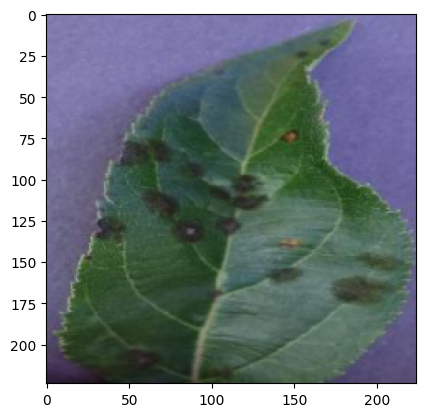

1.0
Number of samples in train_dataset: 73006
Number of samples in val_dataset_plant: 18250
Batch size: 64
Image shape (C, H, W): torch.Size([3, 224, 224])
Label example: 1.0


In [12]:
import torchvision.utils

import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataset)
next(dataiter)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)

print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Number of samples in val_dataset_plant: {len(val_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Image shape (C, H, W): {images.shape}")
print(f"Label example: {labels}")

## Models

In [13]:
class CNN(nn.Module):
    def __init__(self, num_classes=1):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4, 4),

            nn.Conv2d(16, 16, kernel_size=15, padding=7),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4, 4),

        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16 * int(width/(2**7)) * int(height/(2**7)), 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.reshape(-1)

## Training

In [14]:
def log_metrics_to_tensorboard(model_name, epoch, test_loss):
    writer.add_scalar(f'{model_name}/test_loss', test_loss, epoch)

def log_accuracy_to_tensorboard(model_name, epoch, accuracy):
    writer.add_scalar(f'{model_name}/accuracy', accuracy, epoch)

In [15]:
def train_model(model, optimizer, scheduler, criterion = nn.BCELoss(), num_epochs=1000):
    # Calculate the total number of parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total number of parameters: {total_params}')

    # Move the model to GPU if available
    print(device)
    model.to(device)

    # Training loop with early stopping
    patience = 2
    best_val_loss = float('inf')
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(training_loader, desc="Training"):
            images = images.to(device)
            labels = labels.to(device)
            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.detach().item()

            # Backward pass
            loss.backward()
            optimizer.step()

        scheduler.step()
        print(f'Training loss: {running_loss / len(training_loader)}')
        log_metrics_to_tensorboard('CNN', epoch, running_loss / len(training_loader))
        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(validation_loader, desc="Validation"):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Convert the outputs to predicted class labels
                predicted = (outputs>0.5).float() #torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        print(f'Validation loss: {val_loss / len(validation_loader)}')
        print(f'Validation accuracy: {val_accuracy:.4f}')
        log_accuracy_to_tensorboard('CNN', epoch, val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = patience_counter - 1 if patience_counter > 0 else 0
            torch.save(model.state_dict(), 'best_acc_model.pth')
            print(f'Best model saved with valid acc of {val_accuracy:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_val_model.pth')
            print(f'Best model saved with valid loss of {val_loss / len(validation_loader)}')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break


In [16]:

def eval(model):
    model.load_state_dict(torch.load('best_val_model.pth'))
    model.to(device)

    # Make predictions on the test dataset
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for images, label in tqdm(test_loader, desc="Test (eval)"):
            images = images.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            labels.extend(label.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

    # Create a DataFrame with IDs and predictions
    submission_df = pd.DataFrame({
        #'images': test_dataset.labels_df['Images'],
        'labels': predictions,
        'groundtruth': labels
    })
    #submission_df.to_csv('submission.csv', index=False)
    #print('Submission file was created.')
    accuracy = (submission_df.labels == submission_df.groundtruth).mean()
    wrong_assesments = submission_df[submission_df.labels != submission_df.groundtruth]
    false_positives = len(wrong_assesments[wrong_assesments.groundtruth == 1])
    false_negatives = len(wrong_assesments[wrong_assesments.groundtruth == 0])
    print(f"We have {false_positives} false positives and {false_negatives} false negatives!")
    print(f"Accuracy: {accuracy:.4f}")
    return submission_df

In [17]:
import time
def inference_time(model):
    image, label = val_dataset[0]
    image = image.unsqueeze(0)
    model.cpu()
    since = time.time()
    model(image)
    now = time.time()
    now - since

In [18]:
model = CNN()

## Hyperparameters of CNNs

In [19]:
# Training specific hyperparameters
num_epochs = 1000
learning_rate = 0.001
criterion = nn.BCELoss() #  nn.CrossEntropyLoss(label_smoothing=0.1)
weight_decay = 0.0
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) 

## Training start

In [20]:

train_model(model, optimizer,scheduler, criterion, num_epochs=num_epochs)


Total number of parameters: 94689
cuda:0
Epoch 1/1000


Training: 100%|██████████| 1141/1141 [09:33<00:00,  1.99it/s]


Training loss: 0.18237934628865574


Validation: 100%|██████████| 286/286 [02:07<00:00,  2.24it/s]


Validation loss: 0.1008871169048269
Validation accuracy: 0.9651
Best model saved with valid acc of 0.9651
Best model saved with valid loss of 0.1008871169048269
Epoch 2/1000


Training: 100%|██████████| 1141/1141 [08:56<00:00,  2.13it/s]


Training loss: 0.09154092699230552


Validation: 100%|██████████| 286/286 [02:05<00:00,  2.29it/s]


Validation loss: 0.05946783330826768
Validation accuracy: 0.9807
Best model saved with valid acc of 0.9807
Best model saved with valid loss of 0.05946783330826768
Epoch 3/1000


Training: 100%|██████████| 1141/1141 [08:38<00:00,  2.20it/s]


Training loss: 0.07404403953089017


Validation: 100%|██████████| 286/286 [01:44<00:00,  2.73it/s]


Validation loss: 0.05346521936761925
Validation accuracy: 0.9822
Best model saved with valid acc of 0.9822
Best model saved with valid loss of 0.05346521936761925
Epoch 4/1000


Training: 100%|██████████| 1141/1141 [07:45<00:00,  2.45it/s]


Training loss: 0.06346324660817747


Validation: 100%|██████████| 286/286 [01:45<00:00,  2.71it/s]


Validation loss: 0.05269369510923199
Validation accuracy: 0.9868
Best model saved with valid acc of 0.9868
Best model saved with valid loss of 0.05269369510923199
Epoch 5/1000


Training: 100%|██████████| 1141/1141 [08:19<00:00,  2.28it/s]


Training loss: 0.05387783465040954


Validation: 100%|██████████| 286/286 [01:43<00:00,  2.76it/s]


Validation loss: 0.05892610819898096
Validation accuracy: 0.9819
Epoch 6/1000


Training: 100%|██████████| 1141/1141 [07:38<00:00,  2.49it/s]


Training loss: 0.04913494429991015


Validation: 100%|██████████| 286/286 [01:44<00:00,  2.75it/s]


Validation loss: 0.04834352014841688
Validation accuracy: 0.9861
Best model saved with valid loss of 0.04834352014841688
Epoch 7/1000


Training: 100%|██████████| 1141/1141 [07:39<00:00,  2.48it/s]


Training loss: 0.04451030867403221


Validation: 100%|██████████| 286/286 [01:42<00:00,  2.78it/s]


Validation loss: 0.06822881396607312
Validation accuracy: 0.9793
Epoch 8/1000


Training: 100%|██████████| 1141/1141 [08:03<00:00,  2.36it/s]


Training loss: 0.041738632534435514


Validation: 100%|██████████| 286/286 [01:52<00:00,  2.55it/s]


Validation loss: 0.03429398906928387
Validation accuracy: 0.9898
Best model saved with valid acc of 0.9898
Best model saved with valid loss of 0.03429398906928387
Epoch 9/1000


Training: 100%|██████████| 1141/1141 [08:10<00:00,  2.33it/s]


Training loss: 0.03815436081966511


Validation: 100%|██████████| 286/286 [01:48<00:00,  2.63it/s]


Validation loss: 0.04914939298526094
Validation accuracy: 0.9860
Epoch 10/1000


Training: 100%|██████████| 1141/1141 [08:08<00:00,  2.33it/s]


Training loss: 0.03607166744763518


Validation: 100%|██████████| 286/286 [01:49<00:00,  2.62it/s]

Validation loss: 0.08108728174945984
Validation accuracy: 0.9742
Early stopping triggered


In [21]:
eval(model)
inference_time(model)

Test (eval): 100%|██████████| 14/14 [01:34<00:00,  6.72s/it]

We have 53 false positives and 21 false negatives!
Accuracy: 0.9126


In [22]:
#images = []
#for idx, pred, truth in zip(wrong_assesments.index, wrong_assesments["labels"], wrong_assesments["groundtruth"]):
#    if truth == 1:
#        print("False positive - Sick plant classified as healthy:")
#    else:
#        print("False negative - Healthy plant classified as sick:")
#    image, label = test_dataset[idx]
#    imshow(image)
#    images.append(image)

#def imshow(img):
#    img = img / 2 + 0.5     # unnormalize
#    npimg = img.numpy()
#    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#    plt.show()


# get some random training images
#dataiter = iter(train_dataset)
#next(dataiter)
#images, labels = next(dataiter)

# show images
#imshow(torchvision.utils.make_grid(images))
# print labels
#print(labels)

#test_loader

In [24]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8627), started 0:00:22 ago. (Use '!kill 8627' to kill it.)